### 8. Feature extraction

Convert the preprocessed text into numerical features that machine learning models can understand: TF-IDF (Term Frequency-Inverse Document Frequency) to represent each book summary.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')
import os

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data/model_data.csv")
data.head(3)

,title,summary,genre,cleaned_summary,entities,word_count,unique_word_count
0,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",science fiction,alex teenager living near future england lead ...,"[('alex', 'PERSON'), ('england', 'GPE'), ('rus...",588,416
1,The Plague,The text of The Plague is divided into five p...,literary fiction,text plague divided five part town oran thousa...,"[('five', 'CARDINAL'), ('dr bernard rieux', 'P...",609,424
2,All Quiet on the Western Front,"The book tells the story of Paul Bäumer, a Ge...",literary fiction,book tell story paul umer german soldier who u...,"[('paul umer', 'PERSON'), ('german', 'NORP'), ...",375,277


In [4]:
# I'm going to create a function to modify the column of "entities" so that in every row I have the types of entities that appear but not the specific entities.

import ast

# Function to extract the second element from each tuple in the entities string
def extract_element(entities_str):
    # Convert the entities string to a list of tuples
    entities_list = ast.literal_eval(entities_str)
        
    # Check if the list is empty
    if not entities_list:
        return []
        
    # Extract the second element from each tuple
    second_elements = [entity[1] for entity in entities_list]
        
    return second_elements

In [5]:
data['entities'] = data['entities'].apply(extract_element)
data.sample(5)

,title,summary,genre,cleaned_summary,entities,word_count,unique_word_count
5348,Deliverance,Narrated in the first person by one of the ma...,thriller,narrated first person one main character graph...,"[ORDINAL, CARDINAL, CARDINAL, GPE, DATE, GPE, ...",643,393
4159,Who Killed Kennedy,"The book's credited co-writer, fictional jour...",literary fiction,book credited co writer fictional journalist j...,"[PERSON, GPE, PERSON]",30,28
3022,Sharpe's Gold,Major Michael Hogan orders Sharpe to find out...,historical novel,major michael hogan order sharpe find happened...,"[PERSON, PERSON, PERSON, NORP, NORP, PERSON, N...",371,231
2997,The Deviant Strain,"The TARDIS lands the Doctor, Rose and Jack at...",science fiction,tardis land doctor rose jack abandoned soviet ...,"[ORG, PERSON, NORP, DATE]",27,23
3799,Mid-Flinx,This novel does little to expand on Flinx’s m...,science fiction,novel little expand flinx much hinted upcoming...,[],51,45


In [6]:
# Now I'm going to convert the lists of entity categories in the column of "entities" into strings of tokens separated by spaces.
# In this way, we'll have the same format in the columns of "cleaned_summary" and "entities".


# Function to convert a list of strings to lowercase and join them
def convert_entities_to_string(entities_list):
    return ' '.join(entity.lower() for entity in entities_list)

In [7]:
data['entities'] = data['entities'].apply(convert_entities_to_string)
data.sample(6)

,title,summary,genre,cleaned_summary,entities,word_count,unique_word_count
2735,The Lady in the Morgue,Throughout the novel the true identity of the...,thriller,throughout novel true identity young attractiv...,gpe,73,66
7656,Servant of the Empire,"Having risen in wealth, power and social stan...",fantasy,risen wealth power social standing still threa...,person person norp gpe person person person no...,199,155
1231,Netherland,"For while the protagonist, Hans van den Broek...",literary fiction,protagonist han van den broek chooses cricket ...,person norp norp gpe gpe cardinal person gpe,64,59
7594,Friends in Low Places,The story starts in the little town of Menton...,thriller,story start little town menton april angela tu...,cardinal person person person cardinal person ...,499,301
462,Rainbow Six,Central Intelligence Agency operatives John C...,thriller,central intelligence agency operative john cla...,org person person org person org person person...,369,271
655,Foundation's Fear,Emperor Cleon I wants to appoint Hari Seldon ...,science fiction,emperor cleon want appoint hari seldon first m...,person person norp person gpe person gpe perso...,219,143


In [8]:
selected_columns = ['cleaned_summary', 'entities', 'genre']
before_vect = data[selected_columns].copy()
before_vect

,cleaned_summary,entities,genre
0,alex teenager living near future england lead ...,person gpe norp person ordinal person person p...,science fiction
1,text plague divided five part town oran thousa...,cardinal person person person person cardinal ...,literary fiction
2,book tell story paul umer german soldier who u...,person norp norp person org product person per...,literary fiction
3,ged young boy gont one larger island north arc...,person cardinal loc date org cardinal date car...,fantasy
4,living mar deckard acting consultant movie cre...,person,science fiction
...,...,...,...
11008,atticus sullivan last druid life peacefully ar...,person gpe norp norp date date norp norp norp org,fantasy
11009,charlie bucket wonderful adventure begin find ...,person cardinal,fantasy
11010,live dream child born free say like land fathe...,gpe date gpe gpe cardinal,fantasy
11011,rose love dimitri dimitri might love tasha mas...,person date person person person norp date dat...,fantasy


In [9]:
before_vect.rename(columns = {'cleaned_summary':'tokens'}, inplace = True)
before_vect.sample(2)

,tokens,entities,genre
8271,part arthur liz lucy traveling meet rupert ste...,person person person person person person pers...,fantasy
10080,born slave circa slave told born plantation ma...,gpe person date ordinal cardinal date person norp,historical novel


Now we're going to use TF-IDF for the "tokens" column (the preprocessed summaries) and CountVectorizer for the "entities" column.

    1. TF-IDF for tokens: TF-IDF (Term Frequency-Inverse Document Frequency) is a technique commonly used in natural language processing to convert a collection of texts into numerical features. It emphasizes the importance of words by considering both their frequency in a text (term frequency) and their rarity across the entire dataset (inverse document frequency).

    In the "tokens" column, each row represents a summary of a book. TF-IDF helps capture the significance of individual words within each summary and assigns higher weights to words that are frequent in a specific summary but not across all summaries. Summaries often contain words that are indicative of the genre or theme of a book. By using TF-IDF, we can represent each summary as a vector of numerical features that highlight important terms while downplaying common words that may not carry genre-specific information.

    2. CountVectorizer for Entities: the "entities" column contains information about different types of entities mentioned in each summary. These entities can provide valuable information about the content and themes of the book. CountVectorizer will be used to convert the entity types into numerical features by counting the occurrences of each unique entity type in each row. This results in a matrix where each column represents a unique entity type, and the values indicate the count of occurrences for each entity type in a given book.Counting the occurrences of entity types allows us to capture the prevalence of different types of entities in each book. The resulting feature matrix can help the model learn patterns related to the distribution of entity types, which might be indicative of the genre.

After obtaining TF-IDF features for the tokens and count-based features for the entities, we concatenate these features into a single feature matrix. This combined matrix will be used as input to train a machine learning model for predicting book genres. Combining the TF-IDF features with entity count features allows the model to leverage information from both textual content and entity occurrences. This can potentially enhance the model's ability to capture diverse aspects of the book content, leading to a more robust genre prediction.

In [37]:

# TF-IDF vectorization for tokens
tfidf_vectorizer = TfidfVectorizer()
tokens_tfidf = tfidf_vectorizer.fit_transform(before_vect['tokens'].astype(str))

# CountVectorizer for entities
entities_vectorizer = CountVectorizer()
entities_matrix = entities_vectorizer.fit_transform(before_vect['entities'].astype(str))

# Concatenate TF-IDF and entities features
features = pd.concat([pd.DataFrame(tokens_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
                     pd.DataFrame(entities_matrix.toarray(), columns=entities_vectorizer.get_feature_names_out())], axis=1)

### 9. Train_test split

In [38]:
# Split the data into training and testing sets

X = features
y = before_vect['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 10. Model 1: train and test

First of all I'll try two scikit-learn models for classification:
    
    - RandomForest classifier
    
    - Xgboost classifier

Afterwards, if time, perhaps I'll try to train a deep learning model.

In [20]:
# 1. RandomForestClassifier

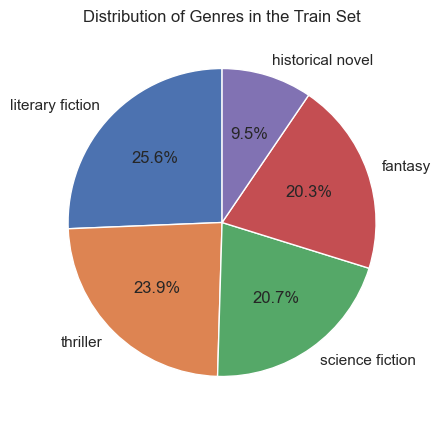

In [48]:
# Visualising the distribution of the 'genre' samples in the train set.

genre_counts = y_train.value_counts()
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Genres in the Train Set')
plt.show()

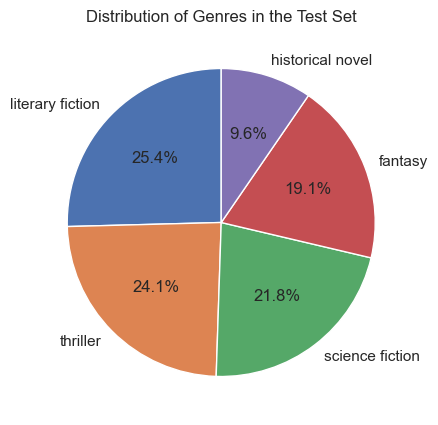

In [50]:
# Visualising the distribution of the 'genre' in the test set

genre_counts_2 = y_test.value_counts()
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(genre_counts_2, labels=genre_counts_2.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Genres in the Test Set')
plt.show()

In [39]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [40]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:

y_pred_train = rf_model.predict(X_train)

In [46]:
from sklearn.metrics import classification_report

# Classification Report (provides precision, recall, f1-score, and support for each class)
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train))

rf_accuracy_0 = accuracy_score(y_train, y_pred_train)
print(f"\nRandomForest Accuracy of the trained data: {rf_accuracy_0}")



Classification Report:
                  precision    recall  f1-score   support

         fantasy       0.99      0.99      0.99      1788
historical novel       0.98      0.96      0.97       837
literary fiction       1.00      1.00      1.00      2259
 science fiction       0.99      0.99      0.99      1820
        thriller       0.98      0.98      0.98      2104

        accuracy                           0.99      8808
       macro avg       0.99      0.99      0.99      8808
    weighted avg       0.99      0.99      0.99      8808


RandomForest Accuracy of the trained data: 0.9896684831970936


In [41]:
y_pred_test = rf_model.predict(X_test)

In [43]:
# Classification Report (provides precision, recall, f1-score, and support for each class)
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

rf_accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nRandomForest Accuracy: {rf_accuracy}")

Classification Report:
                  precision    recall  f1-score   support

         fantasy       0.77      0.71      0.74       421
historical novel       0.38      0.04      0.07       211
literary fiction       0.54      0.82      0.65       560
 science fiction       0.80      0.71      0.75       481
        thriller       0.73      0.70      0.72       530

        accuracy                           0.67      2203
       macro avg       0.64      0.60      0.59      2203
    weighted avg       0.67      0.67      0.65      2203


RandomForest Accuracy: 0.6736268724466636


In [44]:
# Evaluating metrics
accuracy_1 = accuracy_score(y_test, y_pred_test)
precision_1 = precision_score(y_test, y_pred_test, average='macro')
recall_1 = recall_score(y_test, y_pred_test, average='macro')
f1_1 = f1_score(y_test, y_pred_test, average='macro')

print("Accuracy:", accuracy_1*100, '%')
print("Precision:", precision_1*100, '%')
print("Recall:", recall_1*100, '%')
print("F1 score:", f1_1*100, '%')

Accuracy: 67.36268724466636 %
Precision: 64.41847415555043 %
Recall: 59.78786435271354 %
F1 score: 58.6364656254418 %


In [47]:
import pickle

# Save the model to a file using pickle
with open('your_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Now, you can load the model back
# with open('your_rf_model.pkl', 'rb') as file:
# loaded_rf_model = pickle.load(file)

### 11. Model 2: train and test

In [10]:
# 2. XGBoostClassifier
# In this case, I'm going to try to train the model only with the tokens of the summaries (without the entities).
# I'll to create word embeddings of the tokens with Word2Vec to train the model.
# This way, we can check if the model predicts the genre better or worse with only the tokens from the preprocessed summaries, without the entities. 

In [11]:
# When fitting the XGBoostClassifier it's necessary to convert categorical labels into numerical values. 
# So we're going to convert the genres into numerical categories. 

from sklearn.preprocessing import OneHotEncoder

y_encoded = pd.get_dummies(before_vect['genre'], drop_first=True)

In [16]:
!pip install gensim

  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/99/f5/8d2cb0b2628bb6482baafbf0ff7262c11fc46e98b23ee79234828b927e8d/gensim-4.3.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 612.5 kB/s eta 0:00:0000:0100:02


In [20]:
before_vect.isna().sum()

tokens      2
entities    0
genre       0
dtype: int64

In [31]:
# I create my Word2Vec model

from gensim.models import Word2Vec

# Drop rows with NaN values in the 'tokens' column
before_vect_nn = before_vect.dropna(subset=['tokens'])

# If 'tokens' column contains strings, split them into lists of tokens
tokens = before_vect_nn['tokens'].apply(lambda x: x.split() if isinstance(x, str) else x).tolist()

# Train Word2Vec model for tokens
word2vec_model_tokens = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4)

# Save the trained Word2Vec model for tokens
word2vec_model_tokens.save("word2vec_tokens.model")

In [34]:
# Function to get embeddings for a given text column and Word2Vec model
def get_embeddings(text_column, word2vec_model):
    return text_column.apply(lambda text: word2vec_model.wv[text])

# Load Word2Vec model for tokens
word2vec_model_tokens = Word2Vec.load("word2vec_tokens.model")

# Apply the previous function
tokens_embeddings = get_embeddings(before_vect_nn['tokens'], word2vec_model_tokens)

KeyError: "Key 'alex teenager living near future england lead gang nightly orgy opportunistic random ultra violence alex friend droogs novel anglo russian slang nadsat dim slow witted bruiser gang muscle georgie ambitious second in command pete mostly play along droogs indulge taste ultra violence characterized sociopath hardened juvenile delinquent alex also intelligent quick witted sophisticated taste music particularly fond beethoven lovely ludwig van novel begin droogs sitting favorite hangout korova milkbar drinking milk drug cocktail called milk plus hype night mayhem assault scholar walking home public library rob store leaving owner wife bloodied unconscious stomp panhandling derelict scuffle rival gang joyriding countryside stolen car break isolated cottage maul young couple living beating husband raping wife metafictional touch husband writer working manuscript called clockwork orange alex contemptuously read paragraph state novel main theme shredding manuscript back milk bar alex punishes dim crude behaviour strain within gang become apparent home dreary flat alex play classical music top volume fantasizing even orgiastic violence alex skip school next day following unexpected visit deltoid post corrective advisor alex meet pair ten year old girl take back parent flat administers hard drug rape evening alex find droogs mutinous mood georgie challenge alex leadership gang demanding pull man sized job alex quells rebellion slashing dim hand fighting georgie show generosity take bar alex insists following georgie idea burgle home wealthy old woman break in start farce end tragic pathos alex attack kill elderly woman escape blocked dim attack alex leaving incapacitated front step police arrive sentenced prison murder alex get job wing chapel playing religious music stereo service well singing hymn prison chaplain mistake alex bible study stirring faith alex actually reading scripture violent passage alex fellow cellmates blame beating troublesome cellmate death agrees undergo experimental behaviour modification treatment called ludovico technique technique form aversion therapy alex receives injection make feel sick watching graphically violent film eventually conditioning suffer crippling bout nausea mere thought violence unintended consequence soundtrack one films beethoven fifth symphony renders alex unable listen beloved classical music effectiveness technique demonstrated group vip watch alex collapse walloping bully aba scantily clad young woman whose presence aroused predatory sexual inclination though prison chaplain accuses state stripping alex free government official scene pleased result alex released society since parent renting room lodger alex wanders street enters public library hope learn painless way commit suicide accidentally encounter old scholar assaulted earlier book keen revenge beat alex help friend policeman come alex rescue turn none dim former gang rival billyboy two policeman take alex outside town beat dazed bloodied alex collapse door isolated cottage realizing late house droogs invaded first half story gang wore mask assault writer recognize alex writer whose name revealed alexander shelter alex question conditioning sequence revealed mrs alexander died injury inflicted gang rape husband decided continue living fragrant memory persists despite horrid memory alexander critic government hope use alex symbol state brutality thereby prevent incumbent government re elected eventually begin realize alex role happening night two year ago one alexander radical associate manages extract confession alex removing alexander home lock flatblock near former home alex subjected relentless barrage classical music prompting attempt suicide leaping high window alex wake hospital courted government official anxious counter bad publicity created suicide attempt alexander safely packed mental institution alex offered well paying job agrees side government photographer snap picture alex daydream orgiastic violence realizes ludovico conditioning reversed cured right final chapter alex new trio droogs find beginning outgrow taste violence chance encounter pete married settled inspires alex seek wife family contemplates likelihood future son delinquent prospect alex view fatalistically' not present"

In [ ]:
# Split the data again with this last change:

X = features_2
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Set up your features and target variable
X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, target, test_size=0.2, random_state=42)

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {'objective': 'multi:softmax', 'num_class': num_classes, 'seed': 42}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'eval')], early_stopping_rounds=10)

# Make predictions
predictions = model.predict(dtest)

In [14]:
xgb_model = XGBClassifier(random_state=42)

In [15]:
xgb_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:



xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy}")

In [ ]:
# I'm going to ensure that all feature names are unique so that the Xgboost model works better. 

# TF-IDF vectorization for tokens
tfidf_vectorizer = TfidfVectorizer()
tokens_tfidf = tfidf_vectorizer.fit_transform(before_vect['tokens'].astype(str))

# CountVectorizer for entities
entities_vectorizer = CountVectorizer()
entities_matrix = entities_vectorizer.fit_transform(before_vect['entities'].astype(str))

# Get unique names for tokens and entities features
tokens_feature_names = [f'token_{name}' for name in tfidf_vectorizer.get_feature_names_out()]
entities_feature_names = [f'entity_{name}' for name in entities_vectorizer.get_feature_names_out()]

# Rename columns with unique names
tokens_df = pd.DataFrame(tokens_tfidf.toarray(), columns=tokens_feature_names)
entities_df = pd.DataFrame(entities_matrix.toarray(), columns=entities_feature_names)

# Concatenate TF-IDF and entities features
features_2 = pd.concat([tokens_df, entities_df], axis=1)